__Convolution:__ a function derived from two given functions by integration that expresses how the shape of
one is modified by the other. And that’s pretty much what convolution means in the neural networks setting. Convolution is how the original input (in the first convolutional layer, it’s part of the original image) is modified
by the kernel (or filter). [Understanding Convolution](http://colah.github.io/posts/2014-07-Understanding-Convolutions/)

In [ ]:
# Definition:
tf.nn.conv2d (input, filter, strides, padding, use_cudnn_on_gpu=None , data_format=None, name = None)
Input: Batch size x Height x Width x Channels
Filter: Height x Width x Input Channels x Output Channels (e.g. [5 , 5, 3, 64])
Strides: 4 element 1 - D tensor, strides in each direction (often [1, 1, 1, 1] or [1, 2, 2, 1])
Padding: 'SAME' or 'VALID'
Data_format: default to NHWC

Generally, for strides, you don’t want to use any number other than 1 in the first and the fourth dimension,


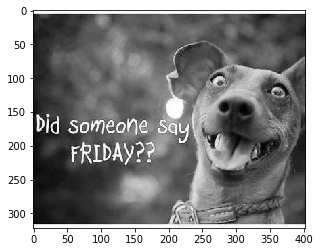

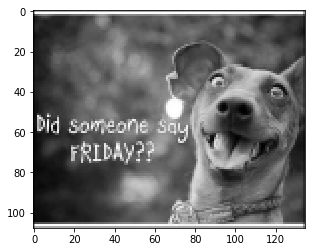

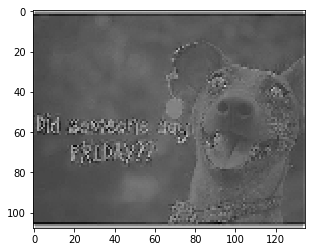

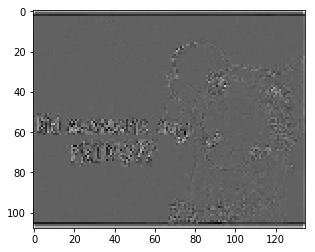

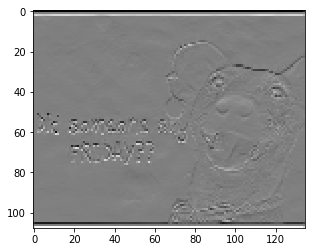

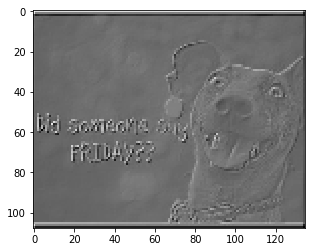

In [1]:
%matplotlib inline
"""
Simple examples of convolution to do some basic filters, Also demonstrates the use of TensorFlow data readers.

We will use some popular filters for our image.
It seems to be working with grayscale images, but not with rgb images.
It's probably because I didn't choose the right kernels for rgb images.

kernels for rgb images have dimensions 3 x 3 x 3 x 3
kernels for grayscale images have dimensions 3 x 3 x 1 x 1

Note:
When you call tf.train.string_input_producer,
a tf.train.QueueRunner is added to the graph, which must be run using
e.g. tf.train.start_queue_runners() else your session will run into deadlock
and your program will crash.

And to run QueueRunner, you need a coordinator to close to your queue for you.
Without coordinator, your threads will keep on running outside session and you will have the error:
ERROR:tensorflow:Exception in QueueRunner: Attempted to use a closed Session.
"""
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import sys
sys.path.append('..')

from matplotlib import gridspec as gridspec
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

# Kernels
a = np.zeros([3, 3, 1, 1])
a[1, 1, :, :] = 1.0
a[0, 1, :, :] = 1.0
a[1, 0, :, :] = 1.0
a[2, 1, :, :] = 1.0
a[1, 2, :, :] = 1.0
a[0, 0, :, :] = 1.0
a[0, 2, :, :] = 1.0
a[2, 0, :, :] = 1.0
a[2, 2, :, :] = 1.0
BLUR_FILTER = tf.constant(a, dtype=tf.float32)

a = np.zeros([3, 3, 1, 1])
a[1, 1, :, :] = 5
a[0, 1, :, :] = -1
a[1, 0, :, :] = -1
a[2, 1, :, :] = -1
a[1, 2, :, :] = -1
SHARPEN_FILTER = tf.constant(a, dtype=tf.float32)

a = np.zeros([3, 3, 1, 1])
a[0, 1, :, :] = -1
a[1, 0, :, :] = -1
a[1, 2, :, :] = -1
a[2, 1, :, :] = -1
a[1, 1, :, :] = 4
EDGE_FILTER = tf.constant(a, dtype=tf.float32)

a = np.zeros([3, 3, 1, 1])
a[0, :, :, :] = 1
a[0, 1, :, :] = 2 # originally 2
a[2, :, :, :] = -1
a[2, 1, :, :] = -2
TOP_SOBEL = tf.constant(a, dtype=tf.float32)

a = np.zeros([3, 3, 1, 1])
a[0, 0, :, :] = -2
a[0, 1, :, :] = -1 
a[1, 0, :, :] = -1
a[1, 1, :, :] = 1
a[1, 2, :, :] = 1
a[2, 1, :, :] = 1
a[2, 2, :, :] = 2
EMBOSS_FILTER = tf.constant(a, dtype=tf.float32)

FILENAME = 'data/friday.jpg'

def load_image(filename):
    """ This is just to demonstrate how to open an image in TensorFlow,
    but it's actually a lot easier to use Pillow 
    """
    filename_queue = tf.train.string_input_producer([filename])
    image_reader = tf.WholeFileReader()
    _, image_file = image_reader.read(filename_queue)
    image = tf.image.decode_jpeg(image_file, channels=3)
    image = tf.cast(image, tf.float32) / 256.0 # cast to float to make conv2d work
    return image

def convolve(image, kernels, strides=[1, 3, 3, 1], padding='SAME'):
    images = [image[0]]
    for i, kernel in enumerate(kernels):
        filtered_image = tf.nn.conv2d(image, kernel, strides=strides, padding=padding)[0]
        images.append(filtered_image)
    return images

# ?
def get_real_images(images):
    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        images = sess.run(images)
        coord.request_stop()
        coord.join(threads)
    return images

def show_images(images):
    for i, image in enumerate(images):
        image = image.reshape(image.shape[0], image.shape[1])
        plt.imshow(image, cmap='gray')
        plt.show()

def main():
    kernels_list = [BLUR_FILTER, SHARPEN_FILTER, EDGE_FILTER, TOP_SOBEL, EMBOSS_FILTER]

    image = load_image(FILENAME)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.expand_dims(image, 0) # make it into a batch of 1 element
    images = convolve(image, kernels_list)
    images = get_real_images(images)
    show_images(images)

main()